# Import Necessary Libraries

In [1]:
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt


# Define the CNN + RNN Model Function

In [2]:
def create_optimized_cnn_rnn_model(input_shape, num_classes):
    # VGG16 backbone for feature extraction
    base_model = VGG16(include_top=False, input_shape=input_shape)
    
    # Unfreeze the last few layers for fine-tuning
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    for layer in base_model.layers[-4:]:
        layer.trainable = True

    # Extract features
    cnn_output = base_model.output
    x = layers.Reshape((49, 512))(cnn_output)  # Reshape CNN output for LSTM
    x = layers.Dropout(0.5)(x)

    # LSTM layer for temporal feature learning
    x = layers.LSTM(256, return_sequences=False, recurrent_dropout=0.25)(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.5)(x)

    # Output layer
    output = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=output)
    
    # Compile the model
    optimizer = optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


# Load the Dataset

### Define Directories

In [3]:
train_dir = 'split_dataset/train'
val_dir = 'split_dataset/val'
test_dir = 'split_dataset/test'


### Visualization of Data

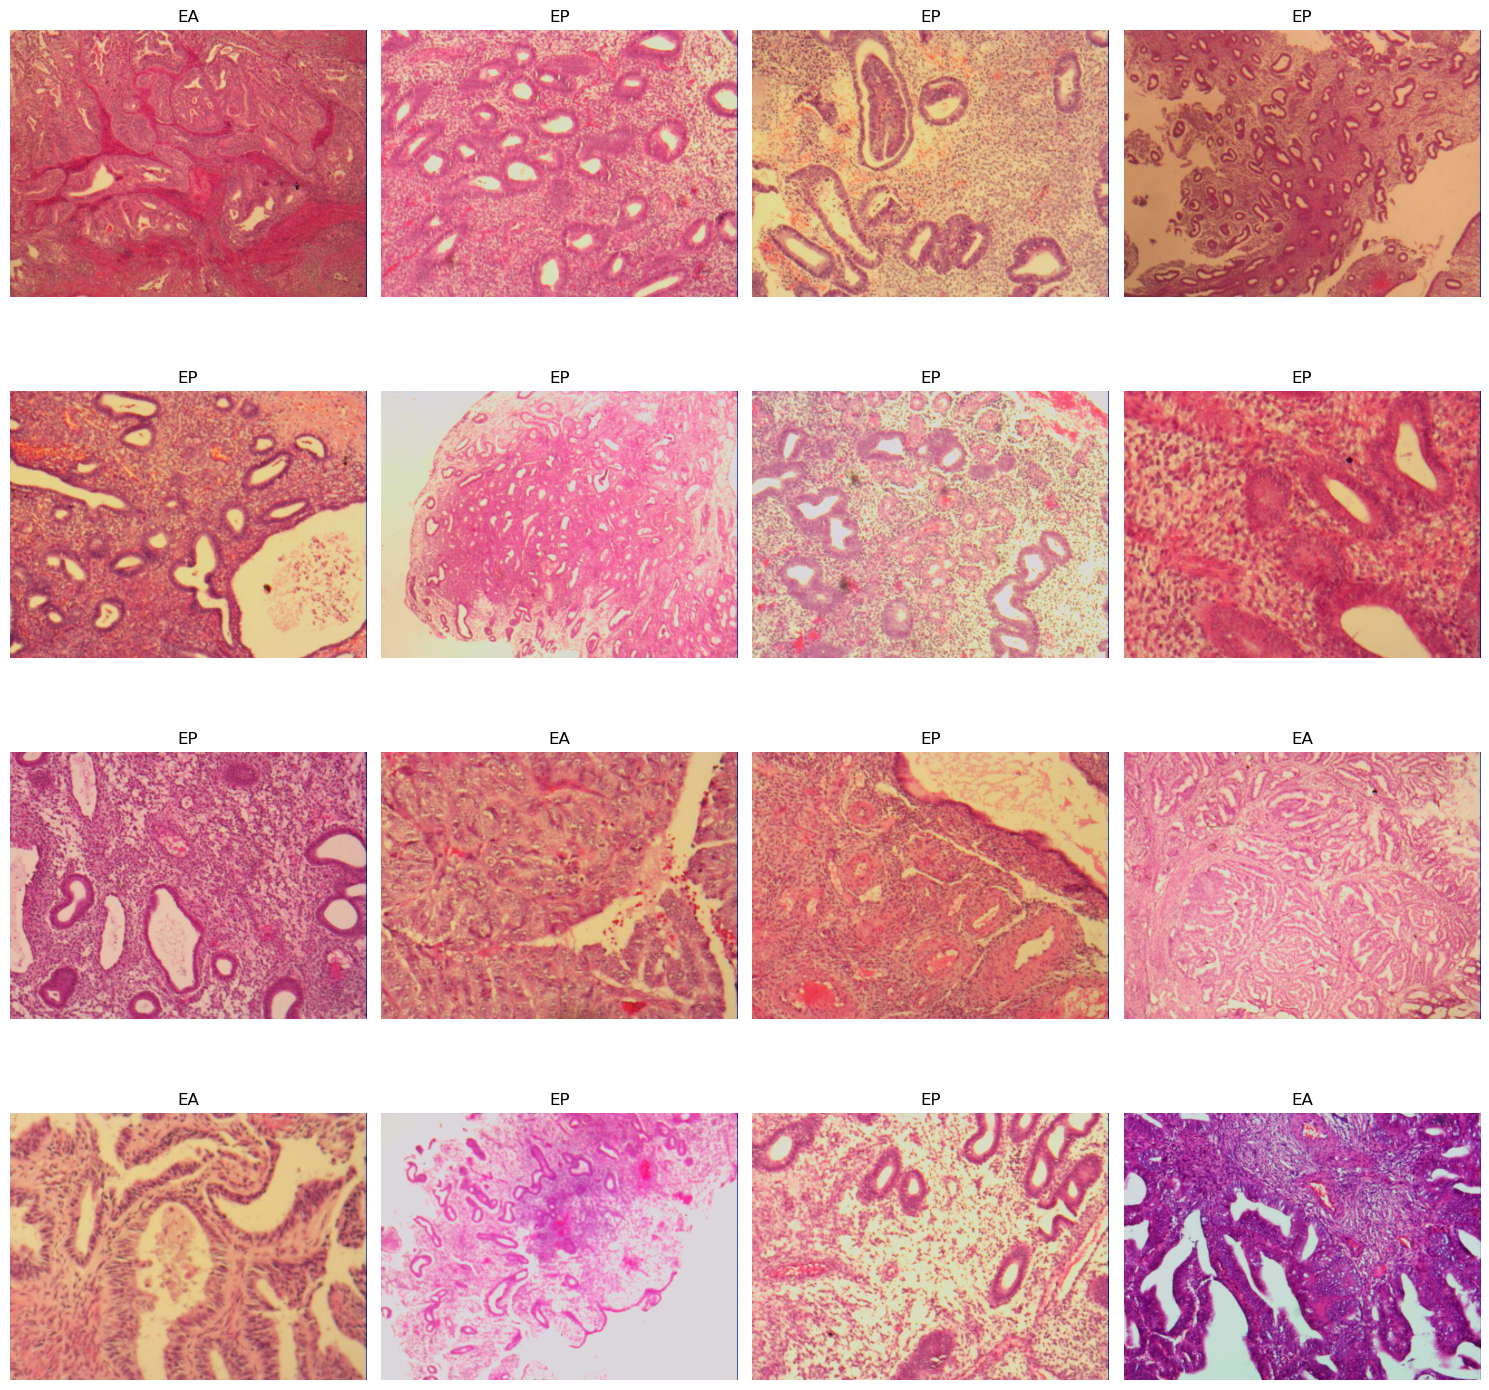

In [51]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the path to the 'train' folder
train_folder = "split_dataset/train"

# Get the list of all subfolders (representing classes: EA, EH, EP, NE)
class_folders = os.listdir(train_folder)

# List to store all image paths and corresponding labels
image_paths = []
image_labels = []

# Loop over each class folder to collect image paths and labels
for class_folder in class_folders:
    class_folder_path = os.path.join(train_folder, class_folder)
    
    if os.path.isdir(class_folder_path):  # Check if it's a valid folder
        # List all images in the class folder
        class_images = os.listdir(class_folder_path)
        
        # Add the image paths and class label to the lists
        for image in class_images:
            image_paths.append(os.path.join(class_folder_path, image))
            image_labels.append(class_folder)  # Label is the folder name (EA, EH, EP, NE)

# Randomly select 16 images from the dataset
selected_indices = random.sample(range(len(image_paths)), 16)

# Prepare the subplots to display the images
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
axes = axes.ravel()

# Display the randomly selected images
for i, idx in enumerate(selected_indices):
    img_path = image_paths[idx]
    label = image_labels[idx]

    # Check if the image exists
    if not os.path.exists(img_path):
        print(f"Image file not found: {img_path}")
        continue

    # Load and display the image
    img = mpimg.imread(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axes
    axes[i].set_title(label)  # Set the class label as title

# Show the plot with the images
plt.tight_layout()
plt.show()


### Data Generators with Augmentation

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Load datasets
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=32, class_mode='categorical'
)
test_generator = val_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)


Found 2308 images belonging to 4 classes.
Found 493 images belonging to 4 classes.
Found 501 images belonging to 4 classes.


# Initialize the Model

In [5]:
input_shape = (224, 224, 3)
num_classes = 4  
model = create_optimized_cnn_rnn_model(input_shape, num_classes)


# Setup Callbacks

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('best_cnn_rnn_model.keras', monitor='val_accuracy', save_best_only=True)


# Train the Model

In [7]:
history = model.fit(
    train_generator,
    vali+dation_data=val_generator,
    epochs=50,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)


Epoch 1/50


C:\Users\jinka\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 509s 7s/step - accuracy: 0.3474 - loss: 2.0414 - val_accuracy: 0.4042 - val_loss: 1.9380 - learning_rate: 1.0000e-04
Epoch 2/50
 1/72 ━━━━━━━━━━━━━━━━━━━━ 7:36 6s/step - accuracy: 0.3438 - loss: 2.0177

C:\Users\jinka\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.3438 - loss: 2.0177 - val_accuracy: 0.3846 - val_loss: 1.9638 - learning_rate: 1.0000e-04
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 573s 8s/step - accuracy: 0.4058 - loss: 1.9504 - val_accuracy: 0.4896 - val_loss: 1.7877 - learning_rate: 1.0000e-04
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.5000 - loss: 1.7956 - val_accuracy: 0.4615 - val_loss: 1.7326 - learning_rate: 1.0000e-04
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 557s 8s/step - accuracy: 0.4345 - loss: 1.8771 - val_accuracy: 0.5479 - val_loss: 1.6575 - learning_rate: 1.0000e-04
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.5312 - loss: 1.6532 - val_accuracy: 0.3846 - val_loss: 1.6967 - learning_rate: 1.0000e-04
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 558s 8s/step - accuracy: 0.5231 - loss: 1.7398 - val_accuracy: 0.5688 - val_loss: 1.7126 - learning_rate: 1.0000e-04
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.5625 - loss: 1.

# Train Accuracy

In [13]:
train_accuracy = history.history['accuracy'][-1]
print(f'Train Accuracy: {train_accuracy:.2f}')


Train Accuracy: 0.78


# Test Accuracy

In [8]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.2f}')


16/16 ━━━━━━━━━━━━━━━━━━━━ 361s 22s/step - accuracy: 0.6670 - loss: 1.4298
Test Accuracy: 0.65


# Generate Classification Report

In [9]:
# Get predictions
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

# Generate report
class_labels = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)


16/16 ━━━━━━━━━━━━━━━━━━━━ 357s 22s/step
              precision    recall  f1-score   support

          EA       0.88      0.74      0.81        81
          EH       0.66      0.63      0.64       122
          EP       0.43      0.62      0.51        96
          NE       0.72      0.64      0.68       202

    accuracy                           0.65       501
   macro avg       0.67      0.66      0.66       501
weighted avg       0.68      0.65      0.66       501



# Test with a Single Image

In [11]:
from tensorflow.keras.preprocessing import image

# Load and preprocess the image
img_path = 'split_dataset/test/EA/1700208-1.jpg'  # Replace with an actual image path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0  # Rescale
img_array = np.expand_dims(img_array, axis=0)

# Make a prediction
prediction = model.predict(img_array)
predicted_class = class_labels[np.argmax(prediction)]
print(f'Predicted class: {predicted_class}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: EA


# Save the Final Model

In [10]:
model.save('optimized_cnn_rnn_model.h5')


# Generate Confusion Matrix

### Import Libraries for the Confusion Matrix

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


### Generate Predictions for the Test Set

In [15]:
y_true = test_generator.classes  # True labels from the test generator
y_pred = np.argmax(model.predict(test_generator), axis=1)  # Predicted labels


16/16 ━━━━━━━━━━━━━━━━━━━━ 398s 25s/step


### Create and Display the Confusion Matrix

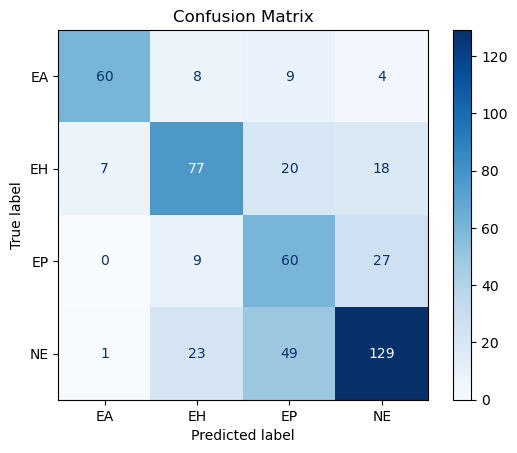

In [16]:
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_generator.class_indices.keys()))
cmd.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


# Visualize Train and Validation Accuracy

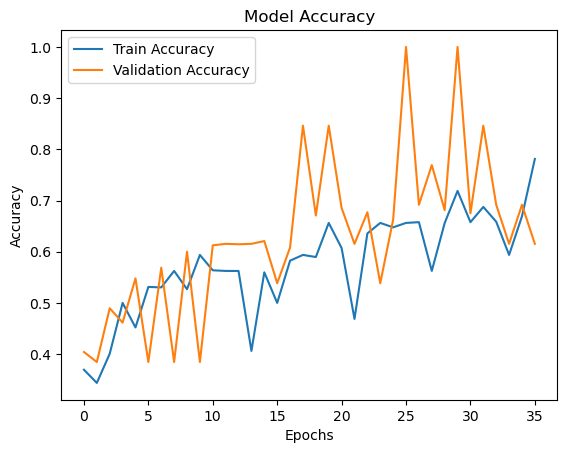

In [12]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()


# Evaluating Model Predictions on Test Data

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


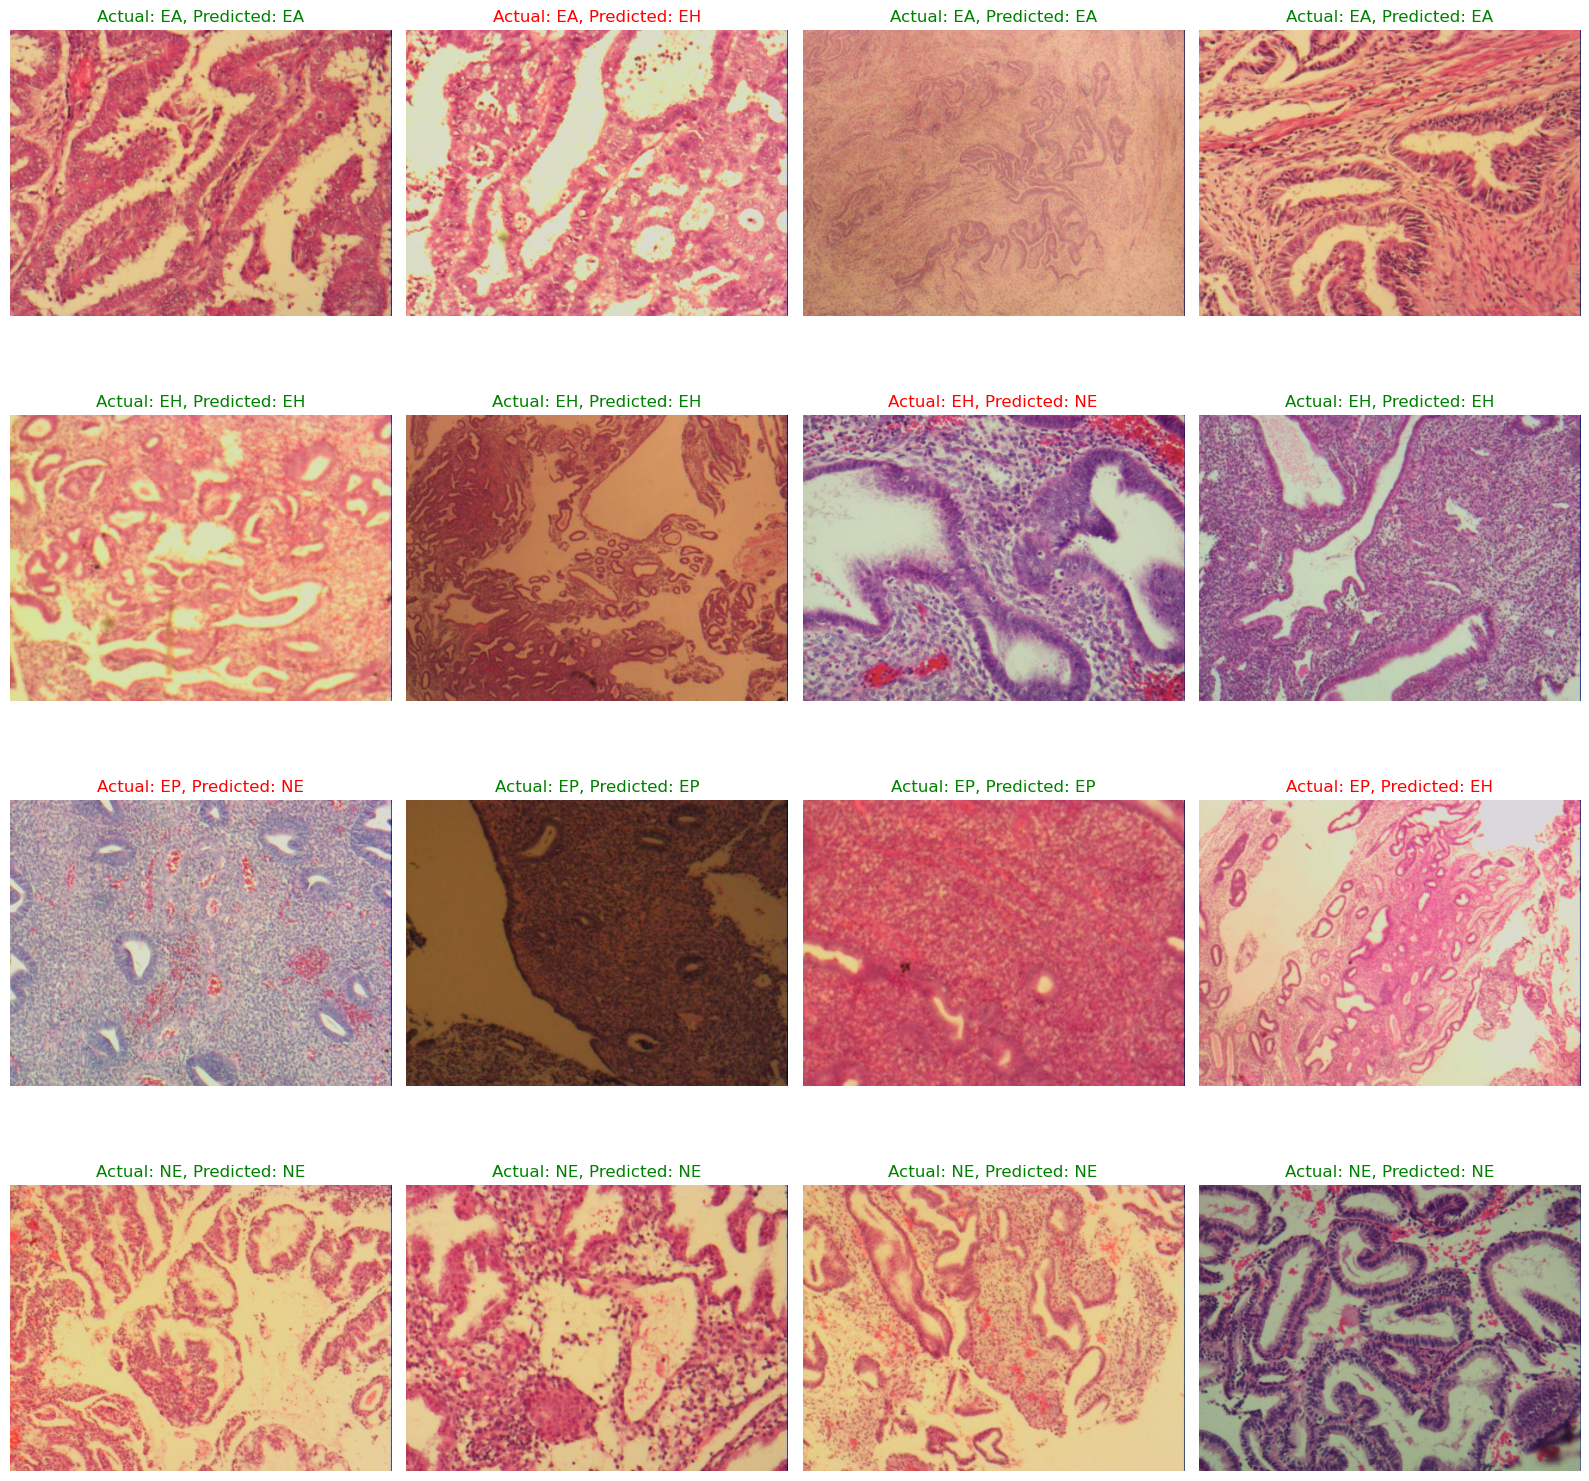

In [42]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import random

# Load the model
model = load_model('optimized_cnn_rnn_model.h5')  # Replace with your model's path

# Path to the test folder
test_folder = 'split_dataset/test'  

# Class names corresponding to EA, EH, EP, NE
class_names = ['EA', 'EH', 'EP', 'NE']

# Function to load and preprocess an image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Adjust target size as per your model's input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize if required
    return img_array

# Function to get actual label from the folder name
def get_actual_label_from_path(path):
    return os.path.basename(path)

# Function to select random images from a folder
def get_random_images_from_folder(folder_path, num_images=4, subfolders=None):
    images = []
    if subfolders:
        for subfolder in subfolders:
            subfolder_path = os.path.join(folder_path, subfolder)
            if os.path.isdir(subfolder_path):
                images += [os.path.join(subfolder_path, img) for img in os.listdir(subfolder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    else:
        images = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    random.shuffle(images)  # Shuffle the images to select randomly
    return images[:num_images]

# Prepare the 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

# Get 4 random images from each category
ea_images = get_random_images_from_folder(os.path.join(test_folder, 'EA'))
eh_images = get_random_images_from_folder(os.path.join(test_folder, 'EH'), subfolders=['simple', 'complex'])
ep_images = get_random_images_from_folder(os.path.join(test_folder, 'EP'))
ne_images = get_random_images_from_folder(os.path.join(test_folder, 'NE'), subfolders=['luteal', 'menstrual', 'follicular'])

# Combine all images for display in a 4x4 grid
all_images = ea_images[:4] + eh_images[:4] + ep_images[:4] + ne_images[:4]

# Loop through each image in the grid and make predictions
for idx, img_path in enumerate(all_images):
    row = idx // 4
    col = idx % 4
    img_array = load_and_preprocess_image(img_path)
    
    # Predict the label
    predicted_label = model.predict(img_array)
    predicted_class_idx = np.argmax(predicted_label, axis=1)[0]  # Get the class index with the highest probability
    predicted_class = class_names[predicted_class_idx]  # Map index to class name
    
    # Get the actual label (folder name for EA, EH, EP, and NE)
    if idx < 4:
        actual_class = 'EA'
    elif idx < 8:
        actual_class = 'EH'
    elif idx < 12:
        actual_class = 'EP'
    else:
        actual_class = 'NE'

    # Display the image
    img = image.load_img(img_path)
    axes[row, col].imshow(img)
    
    # Set title with colors: red for incorrect, green for correct
    if actual_class == predicted_class:
        axes[row, col].set_title(f"Actual: {actual_class}, Predicted: {predicted_class}", color='green')
    else:
        axes[row, col].set_title(f"Actual: {actual_class}, Predicted: {predicted_class}", color='red')
    
    axes[row, col].axis('off')  # Hide axis

plt.tight_layout()
plt.show()
